# File Import

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

DATA_PATH1 = "data/DayAheadPrices_12.1.D/"
DATA_PATH2 = "data/PhysicalFlows_12.1.G/"

file_pattern1 = os.path.join(DATA_PATH1, "*.csv")
file_pattern2 = os.path.join(DATA_PATH2, "*.csv")

def import_csv_files():
    file_list1 = glob.glob(file_pattern1)
    file_list2 = glob.glob(file_pattern2)
    
    dataframes_day_ahead = []
    dataframes_physical_flows = []
    
    
    for file in file_list1:
        df = pd.read_csv(file, sep="\t", parse_dates=["DateTime"])
        dataframes_day_ahead.append(df)
    for file in file_list2:
        df = pd.read_csv(file, sep="\t", parse_dates=["DateTime"])
        dataframes_physical_flows.append(df)
    
    data_day_ahead = pd.concat(dataframes_day_ahead, ignore_index=True)
    data_physical_flows = pd.concat(dataframes_physical_flows, ignore_index=True)
    return data_day_ahead, data_physical_flows

data_day_ahead, data_physical_flow = import_csv_files()

# Task 1

Text(0, 0.5, 'Price')

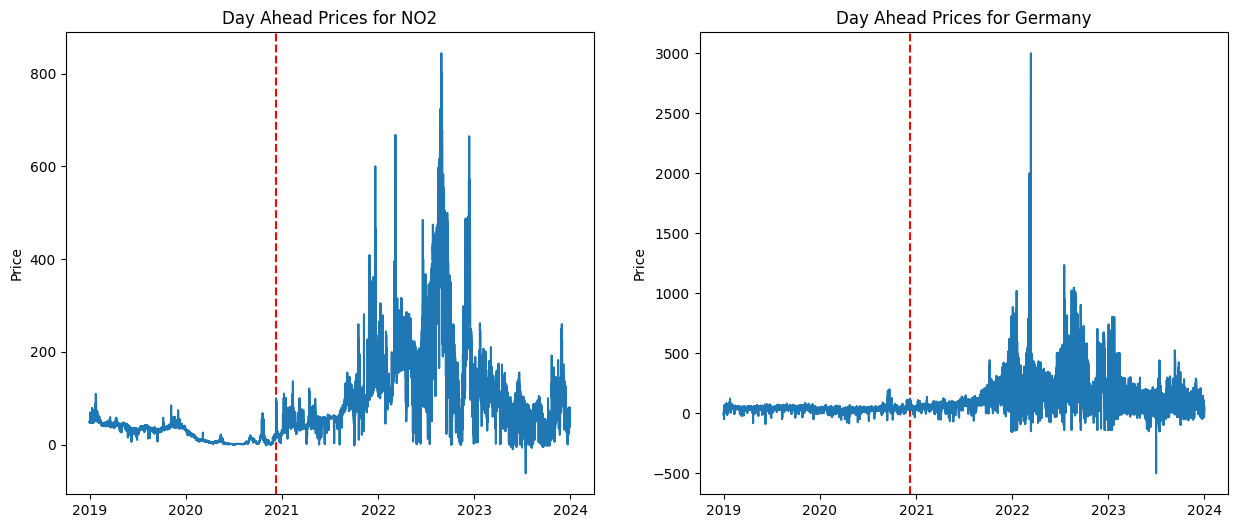

In [29]:
data_day_ahead.head()
data_day_ahead_NO2 = data_day_ahead[data_day_ahead['MapCode'].isin(["NO2"])]
data_day_ahead_DE = data_day_ahead[data_day_ahead['MapCode'].isin(["DE_LU"])]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

data_day_ahead_NO2 = data_day_ahead_NO2.sort_values('DateTime')
data_day_ahead_DE = data_day_ahead_DE.sort_values('DateTime')

ax[0].axvline(x=pd.Timestamp("2020-12-09"), color='red', linestyle='--')
ax[1].axvline(x=pd.Timestamp("2020-12-09"), color='red', linestyle='--')


ax[0].plot(data_day_ahead_NO2['DateTime'], data_day_ahead_NO2['Price'])
ax[0].set_title("Day Ahead Prices for NO2")
ax[0].set_ylabel("Price")

ax[1].plot(data_day_ahead_DE['DateTime'], data_day_ahead_DE['Price'])
ax[1].set_title("Day Ahead Prices for Germany")
ax[1].set_ylabel("Price")

# Task 2

# Task 3

**Step 1 - Limiting in- and outflows to NO2 and DE_LU** 


In [19]:
df = data_physical_flows

df_exports = df[(df["InMapCode"] == "DE_LU") & (df["OutMapCode"] == "NO2")]  # Norway exporting to Germany
df_imports = df[(df["InMapCode"] == "NO2") & (df["OutMapCode"] == "DE_LU")]  # Norway importing from Germany

df_imports = df_imports.set_index("DateTime")
df_exports = df_exports.set_index("DateTime")



**Step 2 - Seperating data by year, and inflow/outflow**

In [20]:
years = ["2019", "2020", "2021", "2022", "2023"]

df_exports_by_year = {}
df_imports_by_year = {}

for year in years:
    if year in df_exports.index:
        df_exports_by_year[year] = df_exports.loc[year]
    if year in df_imports.index:
        df_imports_by_year[year] = df_imports.loc[year]
        



**Step 3 - Calculating the annual sums of exports and imports**

In [21]:
# Initialize dictionaries to store the summed values
value_exports_by_year = {}
value_imports_by_year = {}

# Loop through each year and calculate the annual sums if the data exists
for year in years:
    # Sum exports if data is available for the year
    if year in df_exports_by_year:
        value_exports_by_year[year] = df_exports_by_year[year]["FlowValue"].sum()
    
    # Sum imports if data is available for the year
    if year in df_imports_by_year:
        value_imports_by_year[year] = df_imports_by_year[year]["FlowValue"].sum()

**Step 4 - Preparing the data for plotting by ensuring that each year has a corresponding export or import value**

In [22]:
# Prepare data for plotting
years = [2019, 2020, 2021, 2022, 2023]

# Retrieve export and import values for each year, or use 0 if data is missing
value_exports = [value_exports_by_year.get(str(year), 0) for year in years]
value_imports = [value_imports_by_year.get(str(year), 0) for year in years]

**Step 5 - Plotting the data and saving the plot as a seperate png file**

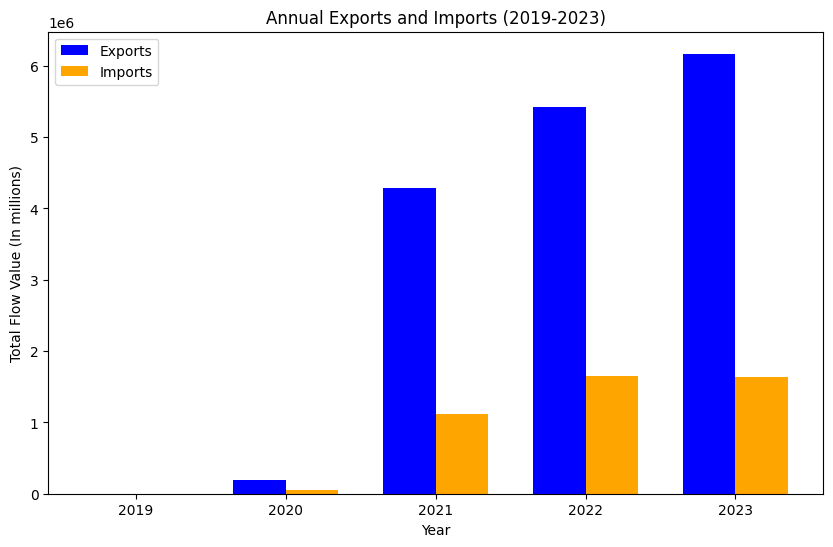

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# Set the bar width
bar_width = 0.35

# Create bar plots for exports and imports
ax.bar([year - bar_width/2 for year in years], value_exports, width=bar_width, label="Exports", color='blue')
ax.bar([year + bar_width/2 for year in years], value_imports, width=bar_width, label="Imports", color='orange')

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Total Flow Value (In millions)')
ax.set_title('Annual Exports and Imports (2019-2023)')
ax.set_xticks(years)
ax.legend()

# Save the plot as a PNG file
plt.savefig("figure_task3.png", format='png', dpi=300)  

# Show the plot
plt.show()

# Task 4

In [ ]:
data_physical_flow = data_physical_flow.sort_values('DateTime')

df_import_from_DE = data_physical_flow[data_physical_flow['OutMapCode'].isin(['DE_LU'])]
df_import_from_NO2 = data_physical_flow[data_physical_flow['OutMapCode'].isin(['NO2'])]

df_NO2_to_DE = df_import_from_DE[df_import_from_DE['InMapCode'].isin(['NO2'])].set_index('DateTime')
df_DE_to_NO2 = df_import_from_NO2[df_import_from_NO2['InMapCode'].isin(['DE_LU'])].set_index('DateTime')

df_NO2_to_DE_weekly = df_NO2_to_DE[['FlowValue']].resample('W').sum()
df_DE_to_NO2_weekly = df_DE_to_NO2[['FlowValue']].resample('W').sum()

df_NO2_to_DE_weekly.reset_index(inplace=True)
df_DE_to_NO2_weekly.reset_index(inplace=True)

# Ensure that both DataFrames have the same DateTime index and are aligned
df_combined = pd.merge(df_NO2_to_DE_weekly, df_DE_to_NO2_weekly, on='DateTime', suffixes=('_NO2_to_DE', '_DE_to_NO2'))

# Subtract the TotalFlowValue from df_DE_to_NO2_weekly from df_NO2_to_DE_weekly
df_combined['FlowDifference'] = df_combined['FlowValue_NO2_to_DE'] - df_combined['FlowValue_DE_to_NO2']

plt.plot(df_combined['DateTime'], df_combined['FlowDifference'])
plt.xticks(rotation=60)
plt.axhline(0, ls="--", color="r")

# Task 5

#### **Step 1:** Formatting data for NO2 and DE

In [42]:
price_data_NO2 = data_day_ahead[data_day_ahead['MapCode'].isin(['NO2'])]
price_data_DE = data_day_ahead[data_day_ahead['MapCode'].isin(['DE_LU'])]

price_data_NO2 = price_data_NO2.set_index('DateTime')
price_data_DE = price_data_DE.set_index('DateTime')

price_data_NO2_weekly = price_data_NO2[['Price']].resample('W').mean()
price_data_DE_weekly = price_data_DE[['Price']].resample('W').mean()

price_differences = pd.merge(price_data_NO2_weekly, price_data_DE_weekly, left_on='DateTime', right_on='DateTime', suffixes=('_NO2', '_DE'))
price_differences['Difference'] = price_differences['Price_DE'] - price_differences['Price_NO2']


#### **Step 2:** Formatting Net Exports from NO2

In [39]:
df_import_from_DE = data_physical_flow[data_physical_flow['OutMapCode'].isin(['DE_LU'])]

df_NO2_to_DE = df_import_from_DE[df_import_from_DE['InMapCode'].isin(['NO2'])]
df_NO2_to_DE = df_NO2_to_DE.set_index('DateTime')
df_NO2_to_DE_weekly = df_NO2_to_DE[['FlowValue']].resample('W').sum()



#### **Step 3:** Merge to one DataFrame and calculate the **Correlation Coefficient**

In [40]:
plot_df = pd.merge(price_differences['Difference'], df_NO2_to_DE_weekly['FlowValue'], left_on='DateTime', right_on='DateTime', how='inner')

correlation_coeff = plot_df['FlowValue'].corr(plot_df['Difference'])

#### **Step 4:** Plotting the graph

Text(0.5, 1.0, 'Weekly Average Price Difference (Germany and NO2) with Net Exports from NO2\nCorrelation Coefficient: -0.59')

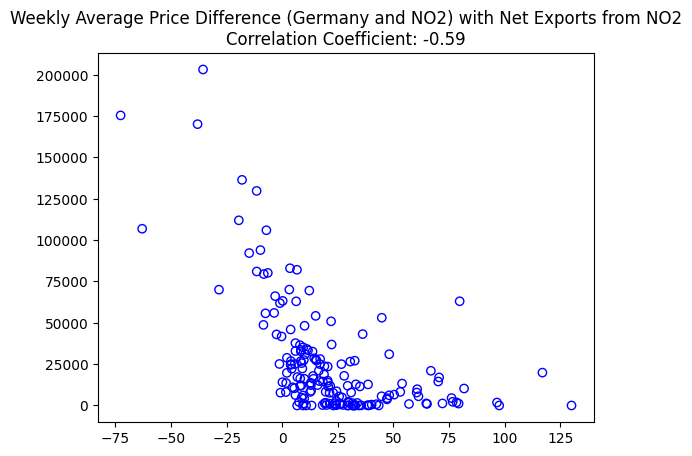

In [43]:
plt.scatter(plot_df['Difference'] ,plot_df['FlowValue'], c='none', edgecolors='blue' )
plt.title(f'Weekly Average Price Difference (Germany and NO2) with Net Exports from NO2\nCorrelation Coefficient: {correlation_coeff:.2f}')

## Conclusion
